## Step1: Read package

#### reference link:
https://www.cricketwa.com/article/76/the-hundred-cricket-venue.aspx#:~:text=Located%20at%20Leeds%2C%20England%2C%20the,the%20vast%20Headingley%20Stadium%20compound.

https://www.espncricinfo.com/series/the-hundred-men-s-competition-2021-1252040/manchester-originals-men-vs-southern-brave-men-19th-match-1252684/full-scorecard

https://en.wikipedia.org/wiki/2022_season_of_The_Hundred

https://en.wikipedia.org/wiki/2021_season_of_The_Hundred#:~:text=Tournament%20structure,-Eight%20city%2Dbased&text=There%20were%2064%20matches%20in,home%20and%20four%20matches%20away.

In [1]:
#general
import pandas as pd
print(pd.__version__)

import numpy as np
import json
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

1.4.2


In [2]:
#Train Test Split
from sklearn.model_selection import train_test_split

#Models and Performance Metrics
# import statsmodels.api as sm

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.pipeline import make_pipeline

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score,recall_score,classification_report
from sklearn.metrics import roc_curve, auc
from scipy.stats import chi2_contingency

from sklearn import svm

from scipy import stats

## Step 2: Building a data frame and Data cleaning
## Question about data frame:

1. Is the variable 'Referee' required? A cricket match has 4 umpires, do we need to split it into 4 columns or make it 1 column (with 4 strings of names in it), I tried to visualise the umpires in the dataframe version1.1_0527 in the file I sent earlier, but found that there can be more than 40+ permutations of umpires in the winning team.


2. Is the variable 'player_of_match'(best player) needed? In the data frame below I've built it anyway and put it in the last column. In cricket it's not only intuitive to focus on the winners and losers, but also on the best player of the match, and since the player_of_match field is given at the beginning of the json file, it's easy to read. There are 93 unique player names in total, so I still deleted this variable later on when visualising and modelling.


3. Match statistics: 'total_score' 'half_score' 'half_wickets' 'total_wickets_player_out' 'total_wickets_field'
   Are all 5 of these variables necessary? Do I need to eliminate anything?
  
  
4. Do I need to split out the "year", "month" and "day" in the "date" and just add the "month" and "day" because the year and season are duplicated? I split the current week's version and looked at the distribution.


5.  I didn't find a significance between toss_winner and home_advantage, do I need to add toss_winner's team name conversion to yes/or?

   
## Points to note:

1.  There was one game where team2's half-time data was not found in the innings_data, probably because team2 did not play, which is the same game as one game no result, which was identified by the news that rain interrupted the game on that day, which is a very special case, so I chose to skip this game directly and created a data frame with only records This was a very special case, so I chose to skip the match and create a data frame with only 123 matches, or 246 rows of data.



2.  When the team with the higher number of wickets lost at half-time (i.e. the variable 'half_wickets') tends to have a losing result;



    
3.  If the wicket lost number at half-time is the same for both teams, one can look at the wicket lost number for the whole match (i.e. the variable 'total_wickets_player_out'), and often the team with the higher variable, its result is also a loss;




4. But the half-time score has no obvious relationship to the result; the full-time score is only used as an auxiliary check on the result.




5.  Wicket type: Bowled; Caught; Run out; Leg before wicket (LBW); Stumped; Hit wicket; Handled the ball; Obstructing the field; Hit the ball twice; Timed out.





6.  In "The Hundred" cricket there are 20 overs per team and each over has 5 deliveries, so the first half should be the first 10 overs, i.e. the first 50 deliveries.


In [3]:
folder_path = os.getcwd() + '/hnd_json/'  
data_frame_list = []

home_venues = {
    "Southern Brave": "The Rose Bowl, Southampton",
    "Birmingham Phoenix": "Edgbaston, Birmingham",
    "Trent Rockets": "Trent Bridge, Nottingham",
    "Oval Invincibles": "Kennington Oval, London",
    "London Spirit": "Lord's, London",
    "Welsh Fire": "Sophia Gardens, Cardiff",
    "Manchester Originals": "Old Trafford, Manchester",
    "Northern Superchargers": "Headingley, Leeds"
}


def calculate_scores_and_wickets_per_match(data_dict):
    scores_wickets = []
    for innings in data_dict["innings"]:
        total_score = 0
        total_wickets_player_out = 0
        total_wickets_field = 0
        half_score = 0
        half_wickets = 0
        over_count = 0

        for over in innings["overs"]:
            for delivery in over["deliveries"]:
                total_score += delivery["runs"]["total"]
                if "wickets" in delivery:
                    total_wickets_player_out += 1
                    if "fielders" in delivery["wickets"][0]:
                        total_wickets_field += len(delivery["wickets"][0]["fielders"])
                # Update half score and wickets if over_count < 10 (for first 10 overs)
                if over_count < 10:
                    half_score += delivery["runs"]["total"]
                    if "wickets" in delivery:
                        half_wickets += 1
            over_count += 1

        scores_wickets.append([total_score, total_wickets_player_out, total_wickets_field, half_score, half_wickets])
    return scores_wickets


for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        with open(os.path.join(folder_path, file_name), 'r') as f:
            data_dict = json.load(f)
            
            info_data = data_dict['info']

            team1 = info_data['teams'][0]
            team2 = info_data['teams'][1]
            
            gender = info_data['gender']
            season = info_data['season']
            
            date = info_data['dates'][0]
            
            match_number = info_data['event'].get('match_number', 'unknown')  
            
            venue = info_data['venue']
            city = info_data['city']
                    
            home_advantage_team1 = 'yes' if home_venues[team1] == venue else 'no'
            home_advantage_team2 = 'yes' if home_venues[team2] == venue else 'no'
            #home_advantage and toss_winner may be strong relationship          
            
            
            toss_winner = info_data['toss']['winner']
            toss_decision = info_data['toss']['decision']
            
            choose_to_bat_team1, choose_to_field_team1, forced_to_bat_team1, forced_to_field_team1 = 'no', 'no', 'no', 'no'
            choose_to_bat_team2, choose_to_field_team2, forced_to_bat_team2, forced_to_field_team2 = 'no', 'no', 'no', 'no'
 
            if toss_decision == 'bat':
                if toss_winner == team1:
                    choose_to_bat_team1 = 'yes'
                    forced_to_field_team2 = 'yes'
                else:
                    choose_to_bat_team2 = 'yes'
                    forced_to_field_team1 = 'yes'
            else:
                if toss_winner == team1:
                    choose_to_field_team1 = 'yes'
                    forced_to_bat_team2 = 'yes'
                else:
                    choose_to_field_team2 = 'yes'
                    forced_to_bat_team1 = 'yes'
            
          
            # Set the reverse decision for the losing team based on the toss decision
            toss_decision_loser = 'field' if toss_decision == 'bat' else 'bat'
            toss_decision_team1 = toss_decision if toss_winner == team1 else toss_decision_loser
            toss_decision_team2 = toss_decision if toss_winner == team2 else toss_decision_loser
            
            winner = info_data['outcome'].get('winner', 'no winner')  

            result_team1 = 'win' if winner == team1 else ('loose' if winner == team2 else 'no result')
            result_team2 = 'win' if winner == team2 else ('loose' if winner == team1 else 'no result')
            if result_team1 == 'no result' or result_team2 == 'no result':
                continue
            
            
#             player_of_match = info_data.get('player_of_match', [])
#             player_of_match_team1 = [player for player in player_of_match if player in info_data['players'][team1]]
#             player_of_match_team2 = [player for player in player_of_match if player in info_data['players'][team2]]
#             # checked which team's best player is on the list
#             # Flatten the lists into single strings
#             player_of_match_team1 = ', '.join(player_of_match_team1)
#             player_of_match_team2 = ', '.join(player_of_match_team2)
            
            
            scores_wickets = calculate_scores_and_wickets_per_match(data_dict)

            team1_total_score, team1_total_wickets_player_out, team1_total_wickets_field, team1_half_score, team1_half_wickets = scores_wickets[0]
            team2_total_score, team2_total_wickets_player_out, team2_total_wickets_field, team2_half_score, team2_half_wickets = scores_wickets[1]

            
            
            data_frame_list.append([result_team1, team1, team2, gender, season, date, match_number, venue, city, home_advantage_team1, 
                                    toss_winner, toss_decision_team1,
                                    choose_to_bat_team1, choose_to_field_team1, forced_to_bat_team1, forced_to_field_team1,  
                                    winner, 
                                    team1_total_score,team1_half_score, 
                                    team1_half_wickets, team1_total_wickets_player_out,
                                    team1_total_wickets_field])
            
            data_frame_list.append([result_team2, team2, team1, gender, season, date, match_number, venue, city, home_advantage_team2, 
                                    toss_winner, toss_decision_team2,
                                    choose_to_bat_team2, choose_to_field_team2, forced_to_bat_team2, forced_to_field_team2, 
                                    winner,  
                                    team2_total_score, team2_half_score, team2_half_wickets, 
                                    team2_total_wickets_player_out,
                                    team2_total_wickets_field])
            
        
df = pd.DataFrame(data_frame_list, columns=['Result', 'team', 'opponent', 'gender', 'season','date', 
                                            'match_number', 'venue', 'city', 'home_advantage',
                                            'toss_winner', 'toss_decision', 
                                            'choose_to_bat', 'choose_to_field', 'forced_to_bat', 'forced_to_field',
                                            'winner',
                                            'total_score', 'half_score','half_wickets',
                                            'total_wickets_player_out','total_wickets_field'])

In [4]:
df.head(20) 
#246 rows × 22 columns

,Result,team,opponent,gender,season,date,match_number,venue,city,home_advantage,...,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,winner,total_score,half_score,half_wickets,total_wickets_player_out,total_wickets_field
0,loose,Manchester Originals,Trent Rockets,male,2022,2022-09-03,unknown,"Lord's, London",London,no,...,yes,no,no,no,Trent Rockets,120,60,5,9,5
1,win,Trent Rockets,Manchester Originals,male,2022,2022-09-03,unknown,"Lord's, London",London,no,...,no,no,no,yes,Trent Rockets,121,57,3,8,7
2,loose,Trent Rockets,Southern Brave,male,2022,2022-08-25,25,"The Rose Bowl, Southampton",Southampton,no,...,no,no,yes,no,Southern Brave,138,59,2,6,3
3,win,Southern Brave,Trent Rockets,male,2022,2022-08-25,25,"The Rose Bowl, Southampton",Southampton,yes,...,no,yes,no,no,Southern Brave,142,52,2,4,2
4,loose,Welsh Fire,Southern Brave,female,2021,2021-07-27,8,"Sophia Gardens, Cardiff",Cardiff,yes,...,no,no,yes,no,Southern Brave,110,53,4,7,7
5,win,Southern Brave,Welsh Fire,female,2021,2021-07-27,8,"Sophia Gardens, Cardiff",Cardiff,no,...,no,yes,no,no,Southern Brave,112,61,2,2,2
6,loose,Northern Superchargers,London Spirit,male,2022,2022-08-14,13,"Headingley, Leeds",Leeds,yes,...,yes,no,no,no,London Spirit,143,58,2,5,5
7,win,London Spirit,Northern Superchargers,male,2022,2022-08-14,13,"Headingley, Leeds",Leeds,no,...,no,no,no,yes,London Spirit,147,107,1,3,2
8,loose,Manchester Originals,Welsh Fire,female,2021,2021-07-31,12,"Sophia Gardens, Cardiff",Cardiff,no,...,no,no,yes,no,Welsh Fire,120,43,2,6,7
9,win,Welsh Fire,Manchester Originals,female,2021,2021-07-31,12,"Sophia Gardens, Cardiff",Cardiff,yes,...,no,yes,no,no,Welsh Fire,124,73,1,1,1


### Duplicate allocation of data frame columns and sorted by 'date' and 'season', 
### change 'date' into 'month' and 'day'

Result is relevant (as this is the target to be predicted):
'Result'
'winner'

Match information:
'team'
'opponent'
'gender'
'season'
'month'
'day'
'match_number'

Match venue information:
'avenue'
'city'
'home_advantage'

Tactical decisions for the match:
'toss_winner'
'toss_decision'
'choice_to_bat'
'choice_to_field'
'forced_to_bat'
'forced_to_field'

Match statistics:
'total_score'
'half_score'
'half_wickets'
'total_wickets_player_out'
'total_wickets_field'

In [5]:
# convert 'date' to datetime object
df['date'] = pd.to_datetime(df['date'])

# sort by 'season' and 'date'
df = df.sort_values(by=['season', 'date'])

df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(columns=['date'])

column_order = ['Result','winner', 
                'team', 'opponent', 'gender', 'season', 'month','day', 'match_number', 
                'venue', 'city', 'home_advantage',
                'toss_winner', 'toss_decision', 
                'choose_to_bat', 'choose_to_field', 'forced_to_bat', 'forced_to_field',
                'total_score','half_score','half_wickets','total_wickets_player_out','total_wickets_field']
                                            

df = df[column_order]
df = df.reset_index(drop=True)

In [6]:
# # check the player of match exist
# df[df['player_of_match'].apply(lambda x: len(x) > 0)] 

In [7]:
df

,Result,winner,team,opponent,gender,season,month,day,match_number,venue,...,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,total_score,half_score,half_wickets,total_wickets_player_out,total_wickets_field
0,loose,Oval Invincibles,Manchester Originals,Oval Invincibles,female,2021,7,21,1,"Kennington Oval, London",...,bat,yes,no,no,no,135,59,2,6,6
1,win,Oval Invincibles,Oval Invincibles,Manchester Originals,female,2021,7,21,1,"Kennington Oval, London",...,field,no,no,no,yes,139,58,4,5,4
2,win,Oval Invincibles,Oval Invincibles,Manchester Originals,male,2021,7,22,1,"Kennington Oval, London",...,bat,no,no,yes,no,145,69,4,8,5
3,loose,Oval Invincibles,Manchester Originals,Oval Invincibles,male,2021,7,22,1,"Kennington Oval, London",...,field,no,yes,no,no,136,58,4,7,7
4,loose,London Spirit,Birmingham Phoenix,London Spirit,female,2021,7,23,2,"Edgbaston, Birmingham",...,bat,no,no,yes,no,128,54,3,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,loose,Southern Brave,Trent Rockets,Southern Brave,female,2022,9,2,unknown,"The Rose Bowl, Southampton",...,field,no,yes,no,no,132,51,3,7,5
242,loose,Trent Rockets,Manchester Originals,Trent Rockets,male,2022,9,3,unknown,"Lord's, London",...,bat,yes,no,no,no,120,60,5,9,5
243,win,Trent Rockets,Trent Rockets,Manchester Originals,male,2022,9,3,unknown,"Lord's, London",...,field,no,no,no,yes,121,57,3,8,7
244,loose,Oval Invincibles,Southern Brave,Oval Invincibles,female,2022,9,3,unknown,"Lord's, London",...,bat,yes,no,no,no,101,51,2,7,3


### Data cleaning: About 'match_number'

### Conclusion:

1.  Those without match numbers are semi-finals and finals, while the maximum match number for women's cricket in 2022 is known to be 22 and the maximum match number for all three types of matches, 2022 men, 2021 men and 2021 women, is 32.

2.  To distinguish significantly between the semi-finals and finals, assign a value of 40 to the semi-finals and 50 to the finals.

In [8]:
matches_without_number = df[df.iloc[:,8]=='unknown'] #8 matches 16 rows
matches_without_number

#I found that the 8 matches without a match number all had a common date
#2021-08-20, 2021-08-21
#2022-09-02, 2022-09-03
#The eight races are the knockout and final races for both men and women in each season

,Result,winner,team,opponent,gender,season,month,day,match_number,venue,...,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,total_score,half_score,half_wickets,total_wickets_player_out,total_wickets_field
118,loose,Southern Brave,Trent Rockets,Southern Brave,male,2021,8,20,unknown,"Kennington Oval, London",...,bat,no,no,yes,no,96,57,4,10,9
119,win,Southern Brave,Southern Brave,Trent Rockets,male,2021,8,20,unknown,"Kennington Oval, London",...,field,no,yes,no,no,97,81,2,3,3
120,win,Oval Invincibles,Oval Invincibles,Birmingham Phoenix,female,2021,8,20,unknown,"Kennington Oval, London",...,bat,no,no,yes,no,114,45,3,7,8
121,loose,Oval Invincibles,Birmingham Phoenix,Oval Invincibles,female,2021,8,20,unknown,"Kennington Oval, London",...,field,no,yes,no,no,94,66,3,10,7
122,win,Southern Brave,Southern Brave,Birmingham Phoenix,male,2021,8,21,unknown,"Lord's, London",...,bat,no,no,yes,no,168,65,2,5,4
123,loose,Southern Brave,Birmingham Phoenix,Southern Brave,male,2021,8,21,unknown,"Lord's, London",...,field,no,yes,no,no,136,79,3,5,5
124,win,Oval Invincibles,Oval Invincibles,Southern Brave,female,2021,8,21,unknown,"Lord's, London",...,bat,no,no,yes,no,121,52,1,6,5
125,loose,Oval Invincibles,Southern Brave,Oval Invincibles,female,2021,8,21,unknown,"Lord's, London",...,field,no,yes,no,no,73,21,6,10,9
238,loose,Manchester Originals,London Spirit,Manchester Originals,male,2022,9,2,unknown,"The Rose Bowl, Southampton",...,bat,yes,no,no,no,150,77,2,7,5
239,win,Manchester Originals,Manchester Originals,London Spirit,male,2022,9,2,unknown,"The Rose Bowl, Southampton",...,field,no,no,no,yes,151,101,1,5,3


In [9]:
# Exclude rows where match_number is 'unknown'
matches_with_number = df[df['match_number'] != 'unknown']

# Convert the match_number column to integers
matches_with_number['match_number'] = matches_with_number['match_number'].astype(int)

# Check the minimum, maximum and the distribution of match numbers
min_match_number = matches_with_number['match_number'].min()
max_match_number = matches_with_number['match_number'].max()
distribution = matches_with_number['match_number'].value_counts().sort_index()

print(f'Minimum match number: {min_match_number}')
print(f'Maximum match number: {max_match_number}')
print('Distribution of match numbers:')
print(distribution)

Minimum match number: 1
Maximum match number: 32
Distribution of match numbers:
1     8
2     8
3     8
4     8
5     6
6     8
7     8
8     8
9     4
10    8
11    8
12    8
13    8
14    8
15    8
16    8
17    8
18    8
19    6
20    8
21    8
22    6
23    8
24    8
25    6
26    6
27    6
28    6
29    6
30    6
31    6
32    6
Name: match_number, dtype: int64


/var/folders/1v/gbft9lh97dggng6ytnnwkd9c0000gn/T/ipykernel_48383/3728442574.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_with_number['match_number'] = matches_with_number['match_number'].astype(int)


## Points to note:

1.  Obviously 2021 08 20 is the semi-final, 2021 08 21 is the final, 2022 09 02 is the semi-final and 2022 09 03 is the final. You can also tell from the information on the back that because the men's and women's match numbers for 2021 are up to 32, while the women's match number for 2022 is only up to 24. So I think we should set the match number to 40 for all the semi-finals and 50 for the finals.


     
2.  The women's competition was curtailed due to the inclusion of women's cricket at the 2022 Commonwealth Games in Birmingham, reducing the number of players who were available for the start of the contest. As a result, the women's contest started a week later and each women's team only played six matches in the group stage, meaning some sides did not meet each other at that point in the competition.

In [10]:
# make sure season, month and day are integers
df['season'] = df['season'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)

# define a function to assign match numbers
def assign_match_number(row):
    if row['season'] == 2021 and row['month'] == 8 and row['day'] == 20:
        return 40  # semi-finals
    elif row['season'] == 2021 and row['month'] == 8 and row['day'] == 21:
        return 50  # finals
    elif row['season'] == 2022 and row['month'] == 9 and row['day'] == 2:
        return 40  # semi-finals
    elif row['season'] == 2022 and row['month'] == 9 and row['day'] == 3:
        return 50  # finals
    else:
        return row['match_number']  # keep the original match number

# apply the function to the 'match_number' column
df['match_number'] = df.apply(assign_match_number, axis=1)

# df.loc[df['match_number'] == 'unknown']
# #Out of the group stage and into the semi-finals
# df.loc[df['date'] == '2021-08-20', 'match_number'] = 40 
# df.loc[df['date'] == '2022-09-02', 'match_number'] = 40
# #Come to the final
# df.loc[df['date'] == '2021-08-21', 'match_number'] = 50
# df.loc[df['date'] == '2022-09-03', 'match_number'] = 50

In [11]:
df[df['match_number']==40]

,Result,winner,team,opponent,gender,season,month,day,match_number,venue,...,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,total_score,half_score,half_wickets,total_wickets_player_out,total_wickets_field
118,loose,Southern Brave,Trent Rockets,Southern Brave,male,2021,8,20,40,"Kennington Oval, London",...,bat,no,no,yes,no,96,57,4,10,9
119,win,Southern Brave,Southern Brave,Trent Rockets,male,2021,8,20,40,"Kennington Oval, London",...,field,no,yes,no,no,97,81,2,3,3
120,win,Oval Invincibles,Oval Invincibles,Birmingham Phoenix,female,2021,8,20,40,"Kennington Oval, London",...,bat,no,no,yes,no,114,45,3,7,8
121,loose,Oval Invincibles,Birmingham Phoenix,Oval Invincibles,female,2021,8,20,40,"Kennington Oval, London",...,field,no,yes,no,no,94,66,3,10,7
238,loose,Manchester Originals,London Spirit,Manchester Originals,male,2022,9,2,40,"The Rose Bowl, Southampton",...,bat,yes,no,no,no,150,77,2,7,5
239,win,Manchester Originals,Manchester Originals,London Spirit,male,2022,9,2,40,"The Rose Bowl, Southampton",...,field,no,no,no,yes,151,101,1,5,3
240,win,Southern Brave,Southern Brave,Trent Rockets,female,2022,9,2,40,"The Rose Bowl, Southampton",...,bat,no,no,yes,no,134,56,3,6,6
241,loose,Southern Brave,Trent Rockets,Southern Brave,female,2022,9,2,40,"The Rose Bowl, Southampton",...,field,no,yes,no,no,132,51,3,7,5


In [12]:
df[df['match_number']==50]

,Result,winner,team,opponent,gender,season,month,day,match_number,venue,...,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,total_score,half_score,half_wickets,total_wickets_player_out,total_wickets_field
122,win,Southern Brave,Southern Brave,Birmingham Phoenix,male,2021,8,21,50,"Lord's, London",...,bat,no,no,yes,no,168,65,2,5,4
123,loose,Southern Brave,Birmingham Phoenix,Southern Brave,male,2021,8,21,50,"Lord's, London",...,field,no,yes,no,no,136,79,3,5,5
124,win,Oval Invincibles,Oval Invincibles,Southern Brave,female,2021,8,21,50,"Lord's, London",...,bat,no,no,yes,no,121,52,1,6,5
125,loose,Oval Invincibles,Southern Brave,Oval Invincibles,female,2021,8,21,50,"Lord's, London",...,field,no,yes,no,no,73,21,6,10,9
242,loose,Trent Rockets,Manchester Originals,Trent Rockets,male,2022,9,3,50,"Lord's, London",...,bat,yes,no,no,no,120,60,5,9,5
243,win,Trent Rockets,Trent Rockets,Manchester Originals,male,2022,9,3,50,"Lord's, London",...,field,no,no,no,yes,121,57,3,8,7
244,loose,Oval Invincibles,Southern Brave,Oval Invincibles,female,2022,9,3,50,"Lord's, London",...,bat,yes,no,no,no,101,51,2,7,3
245,win,Oval Invincibles,Oval Invincibles,Southern Brave,female,2022,9,3,50,"Lord's, London",...,field,no,no,no,yes,105,59,4,5,1


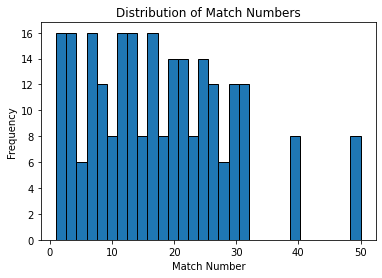

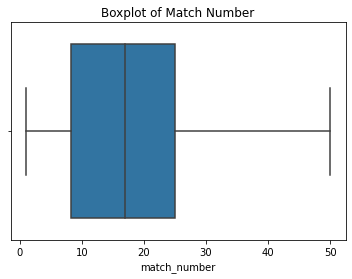

In [13]:
df_copy = df.copy()
df_copy['match_number'] = pd.to_numeric(df_copy['match_number'], errors='coerce')

match_numbers = df_copy['match_number'].dropna()

plt.figure(figsize=(6, 4))
plt.hist(match_numbers, bins=30, edgecolor='black')
plt.title('Distribution of Match Numbers')
plt.xlabel('Match Number')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x=match_numbers)
plt.title('Boxplot of Match Number')
plt.show()

In [14]:
df['match_number'].replace('unknown', np.nan, inplace=True)
df['match_number'] = df['match_number'].astype(float)

def check_match_number_distribution(df, season, gender):
    # Filter dataframe by gender and season and reset index
    df_gender_season = df[(df['gender'] == gender) & (df['season'] == int(season))].reset_index(drop=True)
    
    # Exclude rows where match_number is 'Unknown' or non-numeric
    matches_with_number = df_gender_season[pd.to_numeric(df_gender_season['match_number'], errors='coerce').notna()]
    
    # Convert the match_number column to integers
    matches_with_number['match_number'] = matches_with_number['match_number'].astype(int)
    
    # Check the minimum, maximum and the distribution of match numbers
    min_match_number = matches_with_number['match_number'].min()
    max_match_number = matches_with_number['match_number'].max()
    distribution = matches_with_number['match_number'].value_counts().sort_index()

    print(f'In {season} season for {gender}:')
    print(f'Minimum match number: {min_match_number}')
    print(f'Maximum match number: {max_match_number}')
    print('Distribution of match numbers:')
    print(distribution)
    print('--------------------')

# Check the match number distribution for 2021 and 2022 for both genders
check_match_number_distribution(df, '2021', 'male')
check_match_number_distribution(df, '2021', 'female')
check_match_number_distribution(df, '2022', 'male')
check_match_number_distribution(df, '2022', 'female')

In 2021 season for male:
Minimum match number: 1
Maximum match number: 50
Distribution of match numbers:
1     2
2     2
3     2
4     2
6     2
7     2
8     2
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    2
18    2
20    2
21    2
22    2
23    2
24    2
25    2
26    2
27    2
28    2
29    2
30    2
31    2
32    2
40    2
50    2
Name: match_number, dtype: int64
--------------------
In 2021 season for female:
Minimum match number: 1
Maximum match number: 50
Distribution of match numbers:
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    2
18    2
19    2
20    2
21    2
23    2
24    2
25    2
26    2
27    2
28    2
29    2
30    2
31    2
32    2
40    2
50    2
Name: match_number, dtype: int64
--------------------
In 2022 season for male:
Minimum match number: 1
Maximum match number: 50
Distribution of match numbers:
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     2

In [15]:
df_2021 = df.loc[df['season'] == 2021] 

df_2022 = df.loc[df['season'] == 2022] 

df_2021_men = df_2021.loc[df_2021['gender'] == 'male'] 
df_2021_women = df_2021.loc[df_2021['gender'] == 'female'] 

df_2022_men = df_2022.loc[df_2022['gender'] == 'male'] 
df_2022_women = df_2022.loc[df_2022['gender'] == 'female']

In [16]:
df_2021_men #31 matches, with the deletion of the one with no result
#19th Match (N), Manchester, August 05, 2021

,Result,winner,team,opponent,gender,season,month,day,match_number,venue,...,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,total_score,half_score,half_wickets,total_wickets_player_out,total_wickets_field
2,win,Oval Invincibles,Oval Invincibles,Manchester Originals,male,2021,7,22,1.0,"Kennington Oval, London",...,bat,no,no,yes,no,145,69,4,8,5
3,loose,Oval Invincibles,Manchester Originals,Oval Invincibles,male,2021,7,22,1.0,"Kennington Oval, London",...,field,no,yes,no,no,136,58,4,7,7
6,loose,Birmingham Phoenix,London Spirit,Birmingham Phoenix,male,2021,7,23,2.0,"Edgbaston, Birmingham",...,bat,no,no,yes,no,144,70,3,6,5
7,win,Birmingham Phoenix,Birmingham Phoenix,London Spirit,male,2021,7,23,2.0,"Edgbaston, Birmingham",...,field,no,yes,no,no,148,74,3,7,6
8,loose,Trent Rockets,Southern Brave,Trent Rockets,male,2021,7,24,3.0,"Trent Bridge, Nottingham",...,bat,yes,no,no,no,126,56,4,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,win,Welsh Fire,Welsh Fire,London Spirit,male,2021,8,18,32.0,"Sophia Gardens, Cardiff",...,field,no,yes,no,no,165,93,3,7,4
118,loose,Southern Brave,Trent Rockets,Southern Brave,male,2021,8,20,40.0,"Kennington Oval, London",...,bat,no,no,yes,no,96,57,4,10,9
119,win,Southern Brave,Southern Brave,Trent Rockets,male,2021,8,20,40.0,"Kennington Oval, London",...,field,no,yes,no,no,97,81,2,3,3
122,win,Southern Brave,Southern Brave,Birmingham Phoenix,male,2021,8,21,50.0,"Lord's, London",...,bat,no,no,yes,no,168,65,2,5,4


In [17]:
df_2021_women #32 matches

,Result,winner,team,opponent,gender,season,month,day,match_number,venue,...,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,total_score,half_score,half_wickets,total_wickets_player_out,total_wickets_field
0,loose,Oval Invincibles,Manchester Originals,Oval Invincibles,female,2021,7,21,1.0,"Kennington Oval, London",...,bat,yes,no,no,no,135,59,2,6,6
1,win,Oval Invincibles,Oval Invincibles,Manchester Originals,female,2021,7,21,1.0,"Kennington Oval, London",...,field,no,no,no,yes,139,58,4,5,4
4,loose,London Spirit,Birmingham Phoenix,London Spirit,female,2021,7,23,2.0,"Edgbaston, Birmingham",...,bat,no,no,yes,no,128,54,3,6,3
5,win,London Spirit,London Spirit,Birmingham Phoenix,female,2021,7,23,2.0,"Edgbaston, Birmingham",...,field,no,yes,no,no,132,68,2,7,5
12,loose,Northern Superchargers,Welsh Fire,Northern Superchargers,female,2021,7,24,4.0,"Headingley, Leeds",...,bat,no,no,yes,no,130,79,3,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,win,London Spirit,London Spirit,Welsh Fire,female,2021,8,18,32.0,"Sophia Gardens, Cardiff",...,field,no,yes,no,no,96,77,3,3,2
120,win,Oval Invincibles,Oval Invincibles,Birmingham Phoenix,female,2021,8,20,40.0,"Kennington Oval, London",...,bat,no,no,yes,no,114,45,3,7,8
121,loose,Oval Invincibles,Birmingham Phoenix,Oval Invincibles,female,2021,8,20,40.0,"Kennington Oval, London",...,field,no,yes,no,no,94,66,3,10,7
124,win,Oval Invincibles,Oval Invincibles,Southern Brave,female,2021,8,21,50.0,"Lord's, London",...,bat,no,no,yes,no,121,52,1,6,5


In [18]:
df_2022_men #32 matches +2 matches (Semi-final and final)

,Result,winner,team,opponent,gender,season,month,day,match_number,venue,...,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,total_score,half_score,half_wickets,total_wickets_player_out,total_wickets_field
126,loose,Southern Brave,Welsh Fire,Southern Brave,male,2022,8,3,1.0,"The Rose Bowl, Southampton",...,bat,no,no,yes,no,107,49,4,7,7
127,win,Southern Brave,Southern Brave,Welsh Fire,male,2022,8,3,1.0,"The Rose Bowl, Southampton",...,field,no,yes,no,no,109,72,1,1,1
128,win,London Spirit,London Spirit,Oval Invincibles,male,2022,8,4,2.0,"Kennington Oval, London",...,bat,no,no,yes,no,171,74,3,6,5
129,loose,London Spirit,Oval Invincibles,London Spirit,male,2022,8,4,2.0,"Kennington Oval, London",...,field,no,yes,no,no,168,52,4,7,6
130,loose,Northern Superchargers,Manchester Originals,Northern Superchargers,male,2022,8,5,3.0,"Old Trafford, Manchester",...,bat,no,no,yes,no,161,76,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,loose,Northern Superchargers,Southern Brave,Northern Superchargers,male,2022,8,31,31.0,"Headingley, Leeds",...,field,no,yes,no,no,119,61,5,9,7
238,loose,Manchester Originals,London Spirit,Manchester Originals,male,2022,9,2,40.0,"The Rose Bowl, Southampton",...,bat,yes,no,no,no,150,77,2,7,5
239,win,Manchester Originals,Manchester Originals,London Spirit,male,2022,9,2,40.0,"The Rose Bowl, Southampton",...,field,no,no,no,yes,151,101,1,5,3
242,loose,Trent Rockets,Manchester Originals,Trent Rockets,male,2022,9,3,50.0,"Lord's, London",...,bat,yes,no,no,no,120,60,5,9,5


In [19]:
df_2022_women #24 matches +2 matches (Semi-final and final)

#The following sides did not play each other in the group stage, 
#due to the shortened women's competition: 
#Oval Invincibles and Welsh Fire, 
#Northern Superchargers and Trent Rockets, 
#London Spirit and Manchester Originals, 
#Southern Brave and Birmingham Phoenix.

,Result,winner,team,opponent,gender,season,month,day,match_number,venue,...,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,total_score,half_score,half_wickets,total_wickets_player_out,total_wickets_field
142,loose,Oval Invincibles,Northern Superchargers,Oval Invincibles,female,2022,8,11,1.0,"Kennington Oval, London",...,bat,no,no,yes,no,143,72,3,5,4
143,win,Oval Invincibles,Oval Invincibles,Northern Superchargers,female,2022,8,11,1.0,"Kennington Oval, London",...,field,no,yes,no,no,146,69,0,1,1
146,loose,Southern Brave,London Spirit,Southern Brave,female,2022,8,12,2.0,"The Rose Bowl, Southampton",...,bat,yes,no,no,no,155,65,1,4,2
147,win,Southern Brave,Southern Brave,London Spirit,female,2022,8,12,2.0,"The Rose Bowl, Southampton",...,field,no,no,no,yes,159,90,1,4,2
152,win,Trent Rockets,Trent Rockets,Manchester Originals,female,2022,8,13,3.0,"Old Trafford, Manchester",...,bat,no,no,yes,no,119,57,4,5,3
153,loose,Trent Rockets,Manchester Originals,Trent Rockets,female,2022,8,13,3.0,"Old Trafford, Manchester",...,field,no,yes,no,no,76,40,4,10,7
154,win,Birmingham Phoenix,Birmingham Phoenix,Welsh Fire,female,2022,8,13,4.0,"Sophia Gardens, Cardiff",...,bat,no,no,yes,no,161,91,3,5,4
155,loose,Birmingham Phoenix,Welsh Fire,Birmingham Phoenix,female,2022,8,13,4.0,"Sophia Gardens, Cardiff",...,field,no,yes,no,no,142,75,2,5,6
160,win,Southern Brave,Southern Brave,Oval Invincibles,female,2022,8,14,6.0,"Kennington Oval, London",...,bat,no,no,yes,no,153,77,3,8,8
161,loose,Southern Brave,Oval Invincibles,Southern Brave,female,2022,8,14,6.0,"Kennington Oval, London",...,field,no,yes,no,no,141,68,3,7,3


## Points to note: About 2 seasons of men's and women's matches

According to the official information:

1.    Both men's and women's cricket 2021 will have 32 matches each in the group stage, plus their respective semi-finals and finals, which should give a total of 64+4=68 matches.
2.    However, due to incomplete data, the 2021 men's matches with match_numbers = 5,9,19('no result',deleted) and the 2021 women's matches with match_number = 9,22 are missing, making a total of 4 matches missing and 1 deleted, so the figure for 2021 is only 64 matches.
3.    For the 2022 men's group matches there are 32 matches, plus the semi-finals and finals, making a total of 34 matches;
4.    For the 2022 women's group matches there are 24 matches, plus the semi-finals and finals, making a total of 26 matches.




| Season | 2021 | 2022 | Total matches |
|---------|---------|---------|---------|
|   MEN |   29+2=31 |   32+2=34 | 65    |
|   WOMEN |   30+2=32 |   24+2=26 | 58    |
|   Total matches  |   63 |   60 |   123  |


## Step3:  Exploratory data analysis (included visualisation and statistical tests)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Result                    246 non-null    object 
 1   winner                    246 non-null    object 
 2   team                      246 non-null    object 
 3   opponent                  246 non-null    object 
 4   gender                    246 non-null    object 
 5   season                    246 non-null    int64  
 6   month                     246 non-null    int64  
 7   day                       246 non-null    int64  
 8   match_number              246 non-null    float64
 9   venue                     246 non-null    object 
 10  city                      246 non-null    object 
 11  home_advantage            246 non-null    object 
 12  toss_winner               246 non-null    object 
 13  toss_decision             246 non-null    object 
 14  choose_to_

In [21]:
df.describe()

,season,month,day,match_number,total_score,half_score,half_wickets,total_wickets_player_out,total_wickets_field
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,2021.487805,7.845528,16.918699,17.723577,132.304878,65.475610,2.443089,5.829268,4.479675
std,0.500870,0.443226,9.045548,11.410916,24.609450,14.510989,1.316618,2.466783,2.192192
min,2021.000000,7.000000,1.000000,1.000000,73.000000,21.000000,0.000000,0.000000,0.000000
25%,2021.000000,8.000000,10.000000,8.250000,119.000000,56.000000,2.000000,4.000000,3.000000
50%,2021.000000,8.000000,17.000000,17.000000,132.000000,64.500000,2.000000,6.000000,4.000000
75%,2022.000000,8.000000,24.750000,25.000000,147.000000,74.000000,3.000000,8.000000,6.000000
max,2022.000000,9.000000,31.000000,50.000000,208.000000,108.000000,6.000000,10.000000,11.000000


In [22]:
df.corr()

,season,month,day,match_number,total_score,half_score,half_wickets,total_wickets_player_out,total_wickets_field
season,1.000000,0.487897,0.080861,-0.079148,0.124313,0.035900,-0.032004,0.008219,-0.039259
month,0.487897,1.000000,-0.563079,0.577425,0.004335,0.106027,-0.022120,0.024311,-0.007445
day,0.080861,-0.563079,1.000000,-0.048699,-0.082876,-0.154188,0.029769,0.036326,0.049111
match_number,-0.079148,0.577425,-0.048699,1.000000,-0.138812,-0.006672,0.061163,0.097210,0.085274
total_score,0.124313,0.004335,-0.082876,-0.138812,1.000000,0.597606,-0.308407,-0.279042,-0.222886
half_score,0.035900,0.106027,-0.154188,-0.006672,0.597606,1.000000,-0.428736,-0.357704,-0.324638
half_wickets,-0.032004,-0.022120,0.029769,0.061163,-0.308407,-0.428736,1.000000,0.615309,0.486065
total_wickets_player_out,0.008219,0.024311,0.036326,0.097210,-0.279042,-0.357704,0.615309,1.000000,0.822828
total_wickets_field,-0.039259,-0.007445,0.049111,0.085274,-0.222886,-0.324638,0.486065,0.822828,1.000000


## Points to note:
1.  Correlation between match_number and month is 0.577425; 
2.  Correlation between total_score and half_score is 0.597606; 
3.  Correlation between half_wickets and total_wickets_player_out is 0.615309; 
4.  Correlation between total_wickets_field and total_wickets_player_out is 0.822828;

In [23]:
#checking the missing value
df.isnull().sum()

Result                      0
winner                      0
team                        0
opponent                    0
gender                      0
season                      0
month                       0
day                         0
match_number                0
venue                       0
city                        0
home_advantage              0
toss_winner                 0
toss_decision               0
choose_to_bat               0
choose_to_field             0
forced_to_bat               0
forced_to_field             0
total_score                 0
half_score                  0
half_wickets                0
total_wickets_player_out    0
total_wickets_field         0
dtype: int64

In [24]:
columns_to_check = ['Result','winner',
                    'team', 'opponent', 
                    'gender', 'season', 'month','day',
                    'match_number','venue', 'city', 'home_advantage',
                    'toss_winner', 'toss_decision', 
                    'choose_to_bat','choose_to_field','forced_to_bat','forced_to_field',
                    'total_score','half_score','half_wickets','total_wickets_player_out','total_wickets_field']

#8 teams
#8 venue, because london has two venue
for col in columns_to_check:
    print(f"\nDistribution for column: {col}")
    print(df[col].value_counts())


Distribution for column: Result
loose    123
win      123
Name: Result, dtype: int64

Distribution for column: winner
Southern Brave            46
Oval Invincibles          40
Birmingham Phoenix        36
Trent Rockets             36
Northern Superchargers    26
Manchester Originals      26
London Spirit             24
Welsh Fire                12
Name: winner, dtype: int64

Distribution for column: team
Southern Brave            34
Birmingham Phoenix        32
Trent Rockets             32
Oval Invincibles          31
London Spirit             30
Welsh Fire                30
Manchester Originals      29
Northern Superchargers    28
Name: team, dtype: int64

Distribution for column: opponent
Southern Brave            34
Birmingham Phoenix        32
Trent Rockets             32
Oval Invincibles          31
London Spirit             30
Welsh Fire                30
Manchester Originals      29
Northern Superchargers    28
Name: opponent, dtype: int64

Distribution for column: gender
male 

### Group 1: For variables with only two values

#### 9 variables: 'Result'  'gender' 'season' 'home_advantage' 'toss_decision' 'choice_to_bat' 'choice_to_field' 'forced_to_bat' 'forced_to_field' 

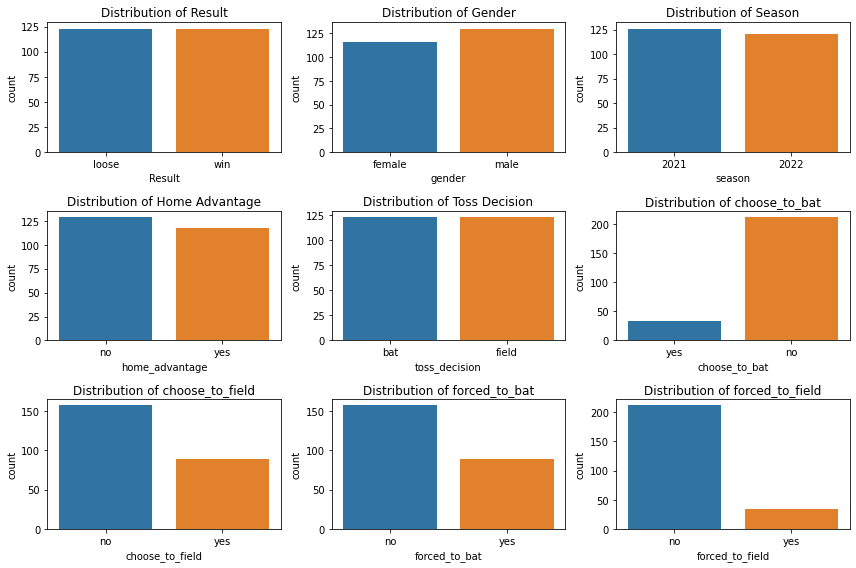

In [25]:
fig, ax = plt.subplots(3, 3, figsize=(12, 8))

sns.countplot(x='Result', data=df, ax=ax[0, 0]) 
ax[0, 0].set_title('Distribution of Result')

sns.countplot(x='gender', data=df, ax=ax[0, 1]) 
ax[0, 1].set_title('Distribution of Gender')

sns.countplot(x='season', data=df, ax=ax[0, 2])
ax[0, 2].set_title('Distribution of Season')

sns.countplot(x='home_advantage', data=df, ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Home Advantage')

sns.countplot(x='toss_decision', data=df, ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Toss Decision')

sns.countplot(x='choose_to_bat', data=df, ax=ax[1, 2])
ax[1, 2].set_title('Distribution of choose_to_bat')

sns.countplot(x='choose_to_field', data=df, ax=ax[2, 0])
ax[2, 0].set_title('Distribution of choose_to_field')

sns.countplot(x='forced_to_bat', data=df, ax=ax[2, 1])
ax[2, 1].set_title('Distribution of forced_to_bat')

sns.countplot(x='forced_to_field', data=df, ax=ax[2, 2])
ax[2, 2].set_title('Distribution of forced_to_field')

plt.tight_layout()
plt.show()

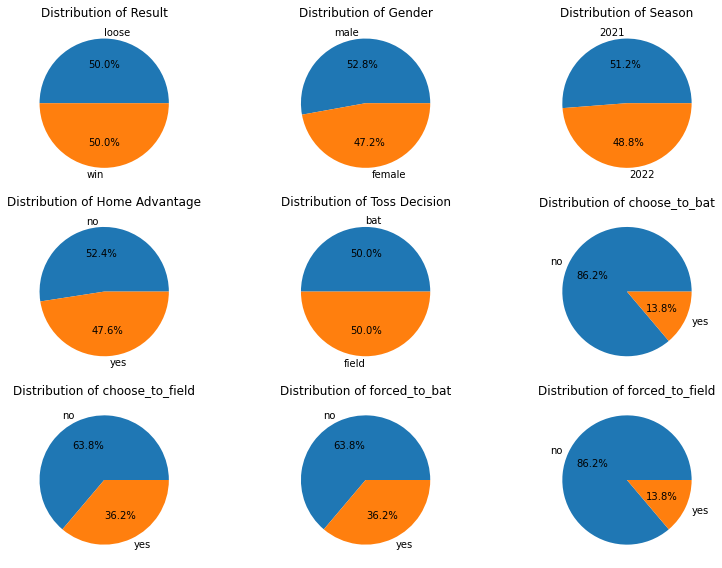

In [26]:
fig, ax = plt.subplots(3, 3, figsize=(12, 8))  

result_counts = df['Result'].value_counts()
ax[0, 0].pie(result_counts, labels = result_counts.index, autopct='%1.1f%%')
ax[0, 0].set_title('Distribution of Result')

gender_counts = df['gender'].value_counts()
ax[0, 1].pie(gender_counts, labels = gender_counts.index, autopct='%1.1f%%')
ax[0, 1].set_title('Distribution of Gender')

season_counts = df['season'].value_counts()
ax[0, 2].pie(season_counts, labels = season_counts.index, autopct='%1.1f%%')
ax[0, 2].set_title('Distribution of Season')

home_advantage_counts = df['home_advantage'].value_counts()
ax[1, 0].pie(home_advantage_counts, labels = home_advantage_counts.index, autopct='%1.1f%%')
ax[1, 0].set_title('Distribution of Home Advantage')

toss_decision_counts = df['toss_decision'].value_counts()
ax[1, 1].pie(toss_decision_counts, labels = toss_decision_counts.index, autopct='%1.1f%%')
ax[1, 1].set_title('Distribution of Toss Decision')

choose_to_bat_counts = df['choose_to_bat'].value_counts()
ax[1, 2].pie(choose_to_bat_counts, labels = choose_to_bat_counts.index, autopct='%1.1f%%')
ax[1, 2].set_title('Distribution of choose_to_bat')

choose_to_field_counts = df['choose_to_field'].value_counts()
ax[2, 0].pie(choose_to_field_counts, labels = choose_to_field_counts.index, autopct='%1.1f%%')
ax[2, 0].set_title('Distribution of choose_to_field')

forced_to_bat_counts = df['forced_to_bat'].value_counts()
ax[2, 1].pie(forced_to_bat_counts, labels = forced_to_bat_counts.index, autopct='%1.1f%%')
ax[2, 1].set_title('Distribution of forced_to_bat')

forced_to_field_counts = df['forced_to_field'].value_counts()
ax[2, 2].pie(forced_to_field_counts, labels = forced_to_field_counts.index, autopct='%1.1f%%')
ax[2, 2].set_title('Distribution of forced_to_field')

plt.tight_layout()
plt.show()

In [27]:
contingency_table_1 = pd.crosstab(df['Result'], df['choose_to_bat'])
chi2, p, dof, expected = chi2_contingency(contingency_table_1)
print(f"Chi-Square Statistic for choice_to_bat: {chi2}, p-value: {p}")

Chi-Square Statistic for choice_to_bat: 4.129578246392897, p-value: 0.042139851839519994


In [28]:
# #Creating interaction items
# df['choice_bat_forced_field'] = df['choose_to_bat'] + "_" + df['forced_to_field']

# contingency_table = pd.crosstab(df['Result'], df['choice_bat_forced_field'])
# chi2, p, dof, expected = chi2_contingency(contingency_table)
# print(f"Chi-Square Statistic for choice_bat_forced_field: {chi2}, p-value: {p}")

### conclusion:

1.  Half win/lose (excluding the one match with no result, indicating that this is a very balanced data set), so we can change it into binary variable (win map to 1, loose map to 0)¶.


2.  Slightly more men's races than women's, with more races in 2021 than in 2022.


3. In theory, each team should have four home games and four away games each season, but due to the reduced season for the 2022 women, there will be slightly less home advantage than if there was no home advantage.


4.  When a team toss wins, it is more likely to actively choose to field, and when a team toss loses, it is more likely to be forced to bat.


|  bat/ field | yes | no | 
|---------|---------|---------|
|  choose to bat /forced to field  |   13.8% | 86.2%   | 
|  choose to field/ forced to bat |   36.2% |   63.8% | 



5.  Choose_to_bat and forced_to_field may have an effect on the Result.

6.  Of this set of variables, only 'choose_to_bat (and arguably forced_to_field) has a significant effect on Result.

###  Group 2: Multicategorical variables 

#### 6 variables:  'winner'  'team' 'opponent' 'toss_winner' 'avenue' 'city' 

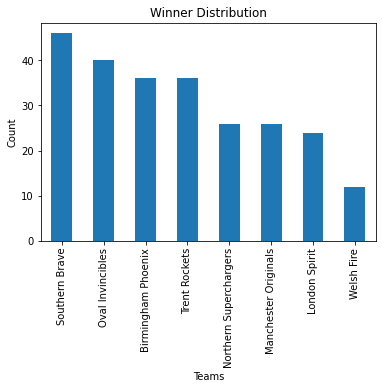

In [29]:
df['winner'].value_counts().plot(kind='bar')
plt.title('Winner Distribution')
plt.xlabel('Teams')
plt.ylabel('Count')
plt.show()                            

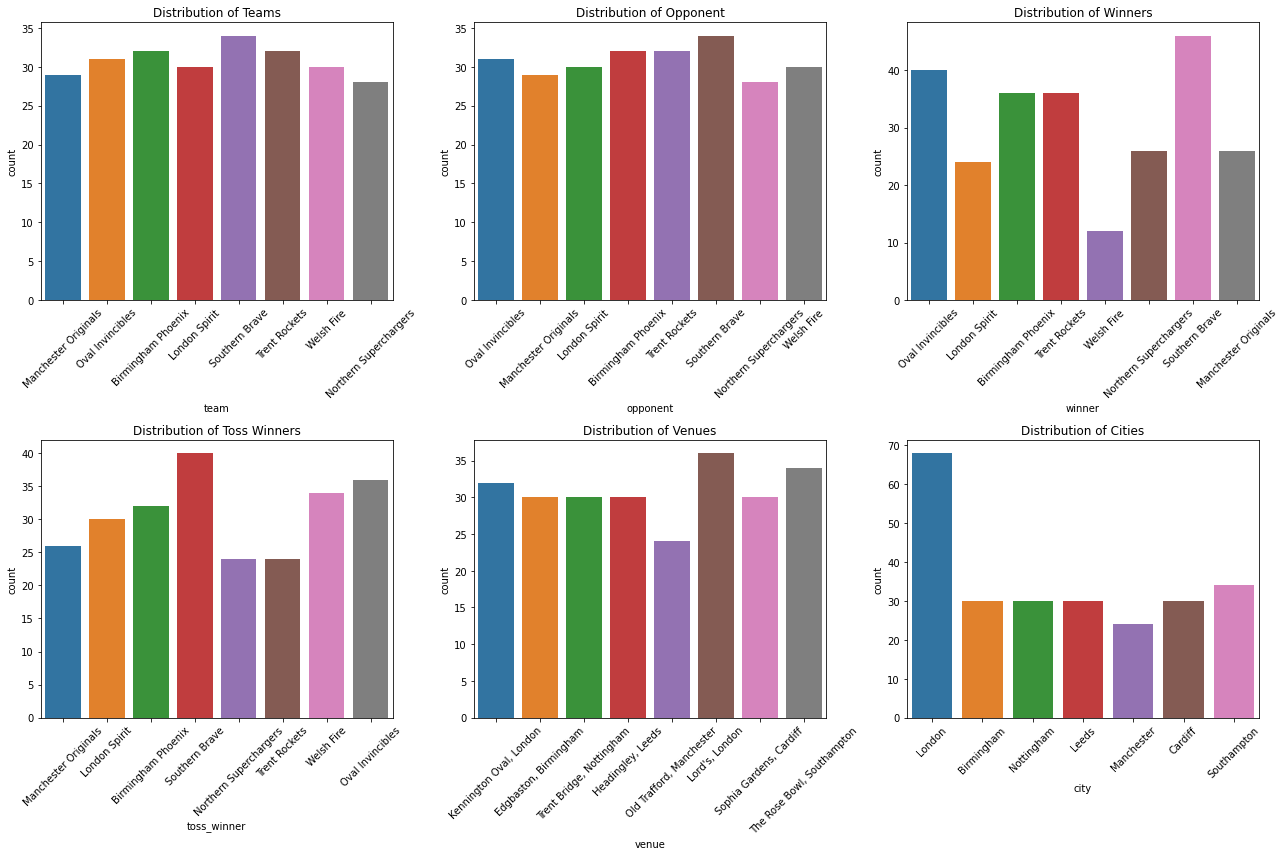

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))  

sns.countplot(x='team', data=df, ax=ax[0,0])
ax[0,0].set_title('Distribution of Teams')
ax[0,0].tick_params(axis='x', rotation=45)

sns.countplot(x='opponent', data=df, ax=ax[0,1])
ax[0,1].set_title('Distribution of Opponent')
ax[0,1].tick_params(axis='x', rotation=45)

sns.countplot(x='winner', data=df, ax=ax[0,2])
ax[0,2].set_title('Distribution of Winners')
ax[0,2].tick_params(axis='x', rotation=45) 

sns.countplot(x='toss_winner', data=df, ax=ax[1, 0])
ax[1,0].set_title('Distribution of Toss Winners')
ax[1,0].tick_params(axis='x', rotation=45) 

sns.countplot(x='venue', data=df, ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Venues')
ax[1, 1].tick_params(axis='x', rotation=45) 

sns.countplot(x='city', data=df, ax=ax[1, 2])
ax[1, 2].set_title('Distribution of Cities')
ax[1, 2].tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()

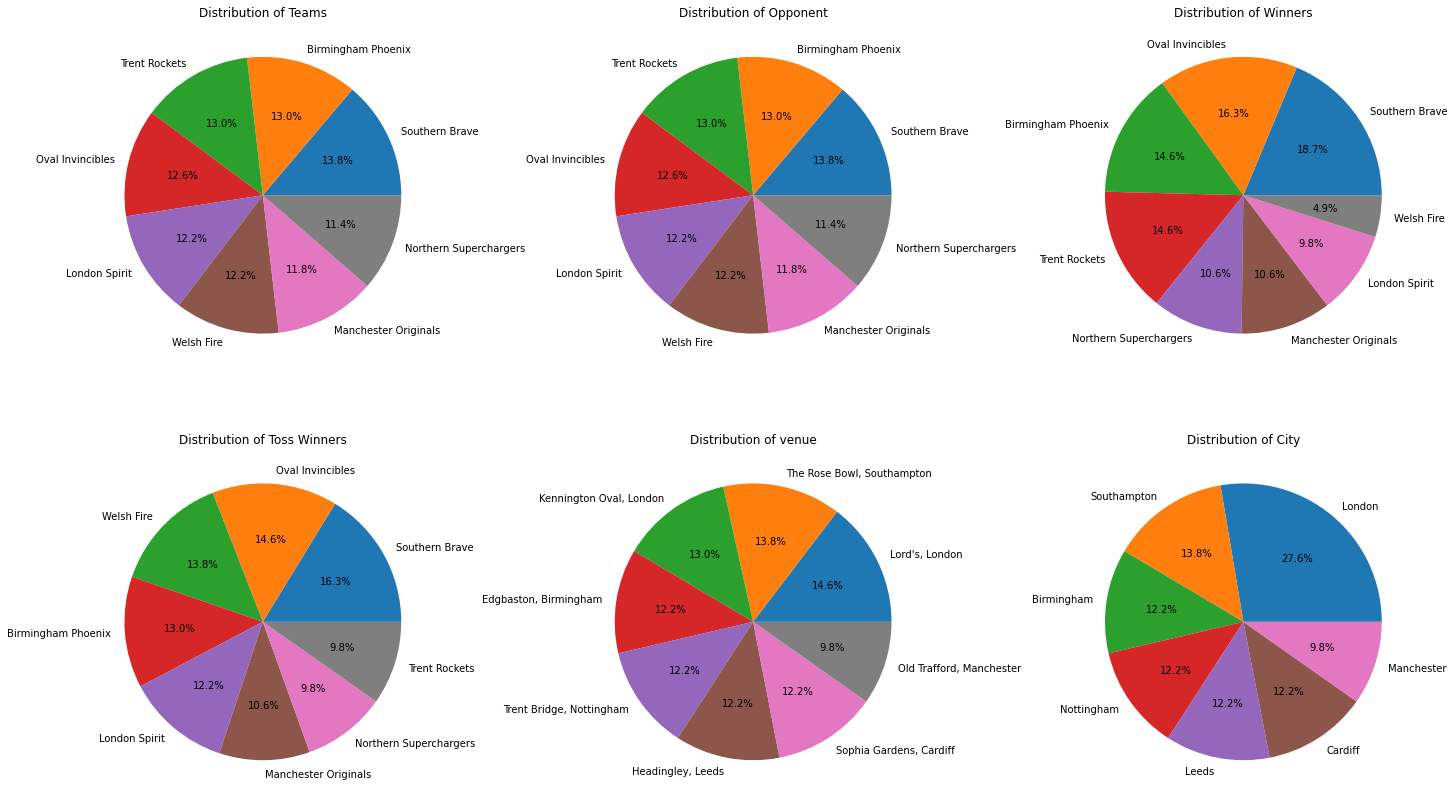

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(20,12))

team_counts = df['team'].value_counts()
ax[0,0].pie(team_counts, labels=team_counts.index, autopct='%1.1f%%')
ax[0,0].set_title('Distribution of Teams')

opponent_counts = df['opponent'].value_counts()
ax[0,1].pie(opponent_counts, labels=opponent_counts.index, autopct='%1.1f%%')
ax[0,1].set_title('Distribution of Opponent')

winner_counts = df['winner'].value_counts()
ax[0,2].pie(winner_counts, labels=winner_counts.index, autopct='%1.1f%%')
ax[0,2].set_title('Distribution of Winners')

toss_winner_counts = df['toss_winner'].value_counts()
ax[1,0].pie(toss_winner_counts, labels=toss_winner_counts.index, autopct='%1.1f%%')
ax[1,0].set_title('Distribution of Toss Winners')

venue_counts = df['venue'].value_counts()
ax[1,1].pie(venue_counts, labels=venue_counts.index, autopct='%1.1f%%')
ax[1,1].set_title('Distribution of venue')

city_counts = df['city'].value_counts()
ax[1,2].pie(city_counts, labels=city_counts.index, autopct='%1.1f%%')
ax[1,2].set_title('Distribution of City')

plt.tight_layout()
plt.show()

In [32]:
#winner and toss_winner
contingency_table = pd.crosstab(df['winner'], df['toss_winner'])
contingency_table

toss_winner,Birmingham Phoenix,London Spirit,Manchester Originals,Northern Superchargers,Oval Invincibles,Southern Brave,Trent Rockets,Welsh Fire
winner,,,,,,,,
Birmingham Phoenix,20,0,0,4,2,2,2,6
London Spirit,0,12,2,4,2,0,0,4
Manchester Originals,4,2,8,2,2,2,0,6
Northern Superchargers,2,2,4,8,4,4,0,2
Oval Invincibles,4,6,4,0,18,4,2,2
Southern Brave,2,4,2,2,4,24,4,4
Trent Rockets,0,4,6,2,2,2,16,4
Welsh Fire,0,0,0,2,2,2,0,6


In [33]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic : {chi2}, p-value : {p}")

Chi-Square Statistic : 288.5792893635172, p-value : 1.1324303576380828e-35


In [34]:
#winner and team
contingency_table = pd.crosstab(df['winner'], df['team'])
contingency_table

team,Birmingham Phoenix,London Spirit,Manchester Originals,Northern Superchargers,Oval Invincibles,Southern Brave,Trent Rockets,Welsh Fire
winner,,,,,,,,
Birmingham Phoenix,18,2,1,3,2,1,5,4
London Spirit,2,12,3,2,1,1,0,3
Manchester Originals,3,1,13,2,1,2,1,3
Northern Superchargers,1,2,3,13,2,2,1,2
Oval Invincibles,3,5,3,2,20,3,2,2
Southern Brave,3,3,1,2,3,23,5,6
Trent Rockets,2,4,4,2,1,1,18,4
Welsh Fire,0,1,1,2,1,1,0,6


In [35]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic : {chi2}, p-value : {p}")

Chi-Square Statistic : 329.2457835602444, p-value : 3.6204070756636475e-43


In [36]:
#winner and city
contingency_table = pd.crosstab(df['winner'], df['city'])
contingency_table

city,Birmingham,Cardiff,Leeds,London,Manchester,Nottingham,Southampton
winner,,,,,,,
Birmingham Phoenix,18,4,4,4,2,4,0
London Spirit,2,2,2,12,4,0,2
Manchester Originals,4,2,4,0,10,2,4
Northern Superchargers,2,2,16,2,2,2,0
Oval Invincibles,2,2,0,32,2,2,0
Southern Brave,0,6,0,10,0,2,28
Trent Rockets,2,4,2,6,4,18,0
Welsh Fire,0,8,2,2,0,0,0


In [37]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic : {chi2}, p-value : {p}")

Chi-Square Statistic : 387.99132063304694, p-value : 1.4636636302841465e-57


In [38]:
# team and toss_winner
contingency_table = pd.crosstab(df['team'], df['toss_winner'])
contingency_table

toss_winner,Birmingham Phoenix,London Spirit,Manchester Originals,Northern Superchargers,Oval Invincibles,Southern Brave,Trent Rockets,Welsh Fire
team,,,,,,,,
Birmingham Phoenix,16,2,1,2,2,3,3,3
London Spirit,2,15,1,3,3,1,2,3
Manchester Originals,3,3,13,2,2,1,1,4
Northern Superchargers,2,1,3,12,4,3,1,2
Oval Invincibles,3,3,2,0,18,3,1,1
Southern Brave,1,3,2,1,3,20,2,2
Trent Rockets,4,2,4,2,2,4,12,2
Welsh Fire,1,1,0,2,2,5,2,17


In [39]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic : {chi2}, p-value : {p}")

Chi-Square Statistic : 329.19195576746483, p-value : 3.7050059778937644e-43


In [40]:
#venue and city
contingency_table = pd.crosstab(df['venue'], df['city'])
contingency_table

city,Birmingham,Cardiff,Leeds,London,Manchester,Nottingham,Southampton
venue,,,,,,,
"Edgbaston, Birmingham",30,0,0,0,0,0,0
"Headingley, Leeds",0,0,30,0,0,0,0
"Kennington Oval, London",0,0,0,32,0,0,0
"Lord's, London",0,0,0,36,0,0,0
"Old Trafford, Manchester",0,0,0,0,24,0,0
"Sophia Gardens, Cardiff",0,30,0,0,0,0,0
"The Rose Bowl, Southampton",0,0,0,0,0,0,34
"Trent Bridge, Nottingham",0,0,0,0,0,30,0


In [41]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Statistic : {chi2}, p-value : {p}")

Chi-Square Statistic : 1476.0, p-value : 3.0032403637055158e-282


### conclusion:

1.  There is a correlation between 'winner' and 'team', 'toss_winner', and 'city'('venue') as all p-values are much less than 0.05. 

2. There is a correlation between 'team' and 'toss_winner', 'city'('venue') as all p-values are much less than 0.05.

3. There is a correlation between toss_winner and 'city'('venue') as all p-values are much less than 0.05.

4. There is clearly a correlation between venue and city, as the p-values are close to 0.

###  Group 3: Numeric variables
#### 8 variables: 'match_number' 'month' 'day' 'total_score' 'half_score' 'half_wickets' 'total_wickets_player_out' 'total_wickets_field'

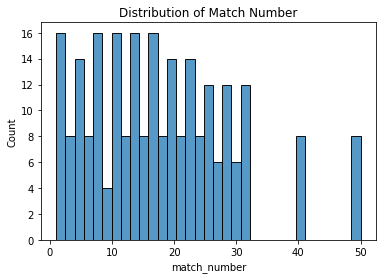

In [42]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x="match_number", bins=33)
plt.title('Distribution of Match Number')
plt.show()

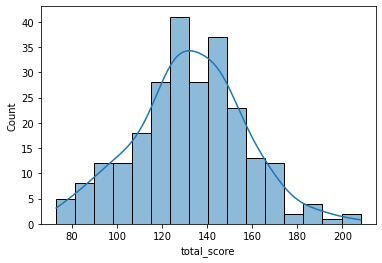

In [43]:
sns.histplot(df['total_score'], kde=True)
plt.show()

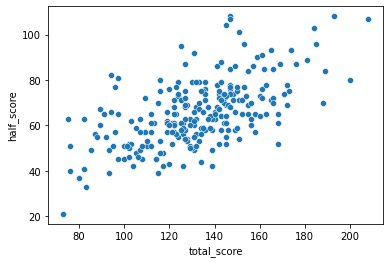

In [44]:
sns.scatterplot(x='total_score', y='half_score', data=df)
plt.show()

In [45]:
correlation = df['total_score'].corr(df['half_score'])
print(f"Correlation between total_score and half_score: {correlation}")

Correlation between total_score and half_score: 0.5976058651501117


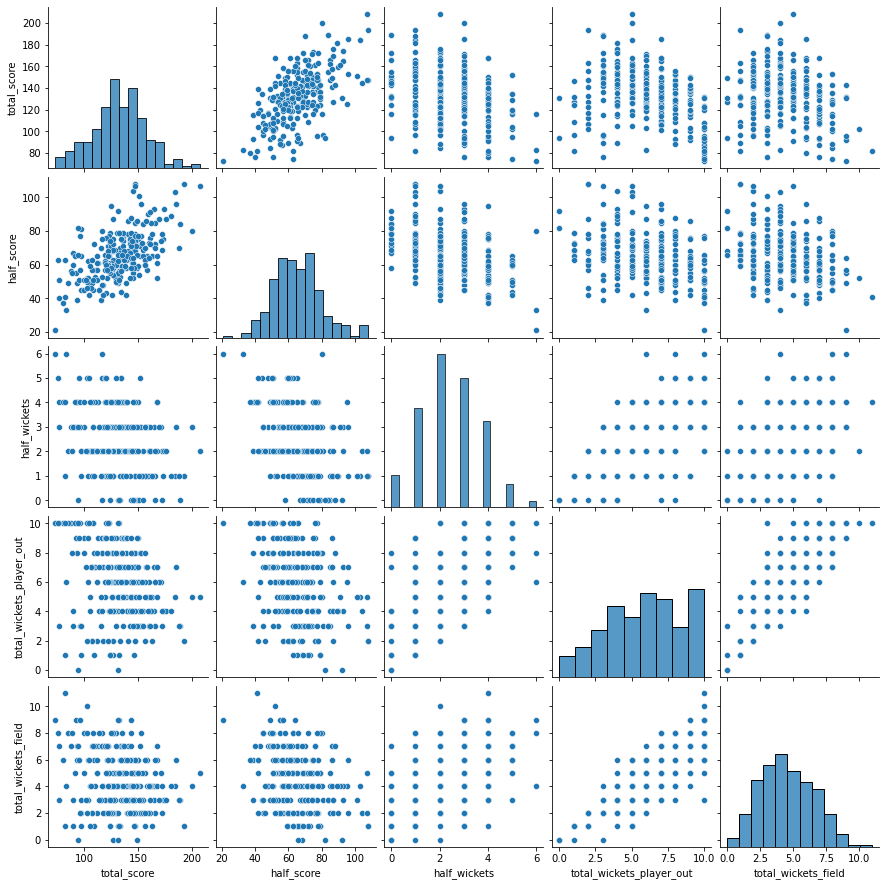

In [46]:
sns.pairplot(df[['total_score', 'half_score', 'half_wickets', 'total_wickets_player_out', 'total_wickets_field']])
plt.show()

In [47]:
# We can run a t-test to see if there is a significant difference in total_score between the winning and losing groups

win_group = df[df['Result'] == 'win']['total_score']
lose_group = df[df['Result'] == 'loose']['total_score']

t_stat, p_val = stats.ttest_ind(win_group, lose_group)
print(f"t-statistic: {t_stat}, p-value: {p_val}")
#Of course there is a significant difference

t-statistic: 3.97232250793724, p-value: 9.37304773438588e-05


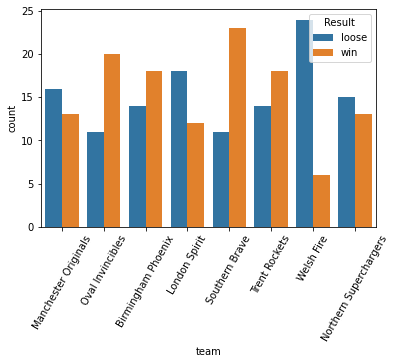

In [48]:
sns.countplot(data=df, x='team', hue='Result')
plt.xticks(rotation=60)
plt.show()

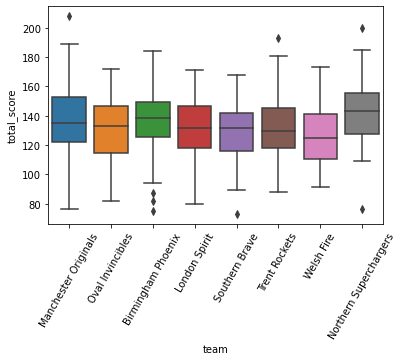

In [49]:
sns.boxplot(data=df, x='team', y='total_score')
plt.xticks(rotation=60)
plt.show()

In [50]:
def perform_tests(df):
    from itertools import combinations

    # Group 1: Binary Variables
    binary_vars = ['Result', 'gender', 'season', 'home_advantage', 'toss_decision', 
                   'choose_to_bat', 'choose_to_field', 'forced_to_bat', 'forced_to_field']

    for var1, var2 in combinations(binary_vars, 2):
        crosstab = pd.crosstab(df[var1], df[var2])
        chi2, p, dof, expected = stats.chi2_contingency(crosstab)
        print(f'p-value of chi-square test between {var1} and {var2}: {p}')

    # Group 2: Multicategorical Variables
    multicategorical_vars = ['winner', 'team', 'opponent', 'toss_winner', 'venue', 'city']

    for var1, var2 in combinations(multicategorical_vars, 2):
        crosstab = pd.crosstab(df[var1], df[var2])
        chi2, p, dof, expected = stats.chi2_contingency(crosstab)
        print(f'p-value of chi-square test between {var1} and {var2}: {p}')

    # Group 3: Numeric Variables
    numeric_vars = ['match_number', 'month', 'day', 'total_score', 'half_score', 
                    'half_wickets', 'total_wickets_player_out', 'total_wickets_field']

    for var1, var2 in combinations(numeric_vars, 2):
        corr, p = stats.pearsonr(df[var1], df[var2])
        print(f'Pearson correlation coefficient between {var1} and {var2}: {corr}')

    # Between Categorical (both binary and multicategorical) and Numeric Variables
    for cat_var in (binary_vars + multicategorical_vars):
        for num_var in numeric_vars:
            groups = [df[num_var][df[cat_var] == category] for category in df[cat_var].unique()]
            f, p = stats.f_oneway(*groups)
            print(f'p-value of ANOVA between {cat_var} and {num_var}: {p}')


perform_tests(df)

p-value of chi-square test between Result and gender: 1.0
p-value of chi-square test between Result and season: 1.0
p-value of chi-square test between Result and home_advantage: 0.12552047765272906
p-value of chi-square test between Result and toss_decision: 0.1259711630772315
p-value of chi-square test between Result and choose_to_bat: 0.042139851839519994
p-value of chi-square test between Result and choose_to_field: 1.0
p-value of chi-square test between Result and forced_to_bat: 1.0
p-value of chi-square test between Result and forced_to_field: 0.042139851839519994
p-value of chi-square test between gender and season: 0.2965337142536466
p-value of chi-square test between gender and home_advantage: 0.9328893984719312
p-value of chi-square test between gender and toss_decision: 1.0
p-value of chi-square test between gender and choose_to_bat: 0.843769111699568
p-value of chi-square test between gender and choose_to_field: 0.8874397177895125
p-value of chi-square test between gender an

### some points:

Total score, half score, and number of wickets seem to have a significant influence on the result of the game. The very small p-values (much less than 0.05) indicate a statistically significant relationship between these factors and the outcome of the match. This makes sense, as these factors directly affect the result of a cricket match.

Gender also seems to have a significant relationship with total score and half score, with very small p-values indicating a statistically significant difference in these variables between genders.

The toss decision seems to have a statistically significant influence on total score and total wickets of the player who is out, which could indicate that the choice of batting or fielding first can have a significant impact on the game's outcome.

The decision to field first (choose_to_field) appears to have a statistically significant relationship with total score and total wickets on the field. This could indicate a possible strategic advantage or disadvantage associated with this decision.

Forced_to_bat and forced_to_field also seem to have a significant relationship with certain game statistics, which could suggest that teams compelled to take a certain action may perform differently.

Venue and city appear to have an influence on match number, day, total score, and half score. This could be due to factors like home advantage, pitch conditions, and weather, which can vary from location to location.

### conclusion:

1.  The Pearson correlation coefficient between match_number and month is 0.577, indicating a moderately strong positive correlation, i.e. as the match number increases, the month increases accordingly.

2.  The Pearson correlation coefficient between total_score and half_score is 0.598, indicating a moderately strong positive correlation between them, i.e. games with high first half scores will usually have a high total score.

3.  The Pearson correlation coefficient for half_wickets and total_wickets_player_out is 0.615, indicating a moderately strong positive correlation, i.e. games with more players out in the first half will usually have more players out for the whole game.

4.  The Pearson correlation coefficient for total_wickets_player_out and total_wickets_field is 0.823, indicating a strong positive correlation between them, meaning that there is a strong positive linear relationship between the total number of players out on the pitch and the number of players out.

## Step 4: Feature Engineering

In [51]:
#Categorical variable processing
df['Result'] = df['Result'].map({'loose': 0, 'win': 1})
df['gender'] = df['gender'].map({'female': 0, 'male': 1})
df['toss_decision']= df['toss_decision'].map({'bat': 0, 'field': 1})
df['home_advantage']=df['home_advantage'].map({'no': 0, 'yes': 1})
df['choose_to_bat']=df['choose_to_bat'].map({'no': 0, 'yes': 1})
df['choose_to_field']=df['choose_to_field'].map({'no': 0, 'yes': 1})
df['forced_to_bat']=df['forced_to_bat'].map({'no': 0, 'yes': 1})
df['forced_to_field']=df['forced_to_field'].map({'no': 0, 'yes': 1})

### Question for transform each category feature: label encoder or dummy?

In [52]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Transform each category feature with label encoding
for col in ['venue', 'city', 'team', 'opponent', 'toss_winner', 'winner']:
    df[col] = label_encoder.fit_transform(df[col])

In [53]:
# df = pd.get_dummies(df, columns=['winner', 'team', 'opponent', 'toss_winner', 'venue', 'city'])

In [54]:
# df = df.drop('player_of_match', axis=1)

In [55]:
df

,Result,winner,team,opponent,gender,season,month,day,match_number,venue,...,toss_decision,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,total_score,half_score,half_wickets,total_wickets_player_out,total_wickets_field
0,0,4,2,4,0,2021,7,21,1.0,2,...,0,1,0,0,0,135,59,2,6,6
1,1,4,4,2,0,2021,7,21,1.0,2,...,1,0,0,0,1,139,58,4,5,4
2,1,4,4,2,1,2021,7,22,1.0,2,...,0,0,0,1,0,145,69,4,8,5
3,0,4,2,4,1,2021,7,22,1.0,2,...,1,0,1,0,0,136,58,4,7,7
4,0,1,0,1,0,2021,7,23,2.0,0,...,0,0,0,1,0,128,54,3,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0,5,6,5,0,2022,9,2,40.0,6,...,1,0,1,0,0,132,51,3,7,5
242,0,6,2,6,1,2022,9,3,50.0,3,...,0,1,0,0,0,120,60,5,9,5
243,1,6,6,2,1,2022,9,3,50.0,3,...,1,0,0,0,1,121,57,3,8,7
244,0,4,5,4,0,2022,9,3,50.0,3,...,0,1,0,0,0,101,51,2,7,3


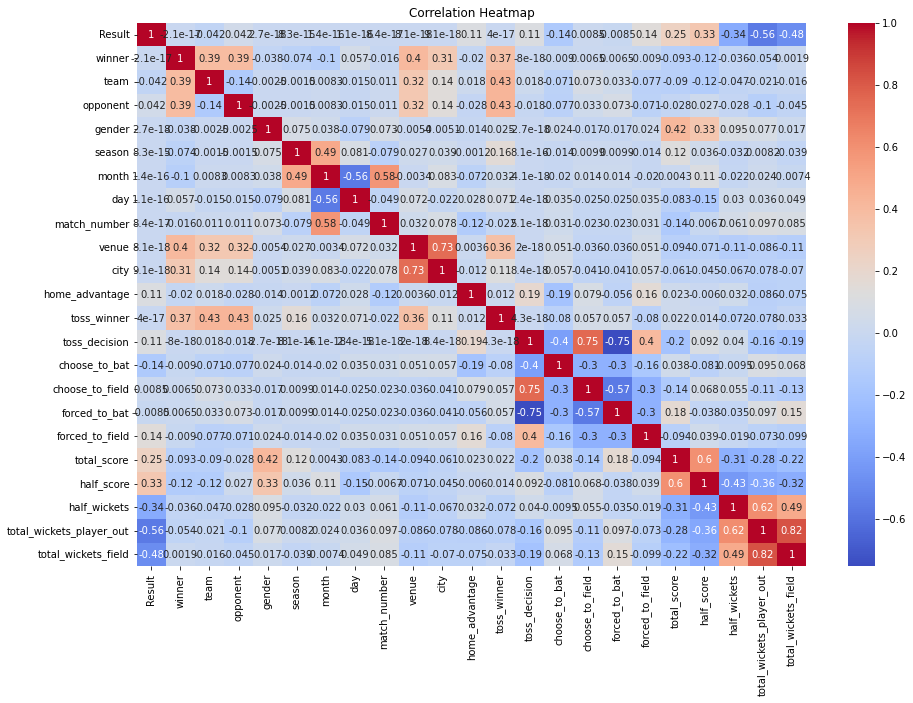

In [56]:
corr_matrix = df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Step 5: PCA and K-means clustering

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = df.values
x = StandardScaler().fit_transform(x) # Standardize the features
# Create a PCA that will retain 80% of the variance
pca = PCA(n_components=0.80, whiten=True)
x_pca = pca.fit_transform(x)

print('Number of PCA components: ', pca.n_components_)

Number of PCA components:  11


Explained Variance:  [0.14483323 0.11737931 0.11271649 0.08694171 0.06687424 0.06174211
 0.05867742 0.05098496 0.04924833 0.0432362  0.03992967]
First 5 rows of transformed features: 
[[ 0.82615674  0.30480683 -0.40540456 -1.84861304  0.9228678   1.36720032
  -1.65894626  0.31178688  0.44452251 -0.28810435  1.36898148]
 [-0.2183817   0.14138772  1.15724747 -2.01782236  0.81874043  0.04163871
   1.81784564 -0.18035419 -0.54805534  0.0538296   1.1543957 ]
 [ 0.48525482  0.62762441 -0.58995971 -1.78949243 -0.98975651  0.29563791
   1.14965562  0.16619014 -1.07883204 -0.70697824 -0.37031031]
 [ 0.73486958  0.06619063  1.19967135 -1.21002936 -1.29241897  1.35237091
  -0.44198296  1.04329675 -0.0051235  -0.60996199 -0.40817866]
 [ 0.8338364   1.67568402  0.05996083 -2.32530248 -0.02700999 -1.15504276
   0.04513409 -0.01626266  0.14685982 -0.89596621  0.15882015]]


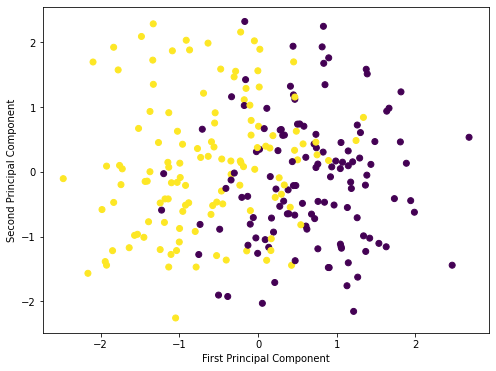

In [58]:
explained_variance = pca.explained_variance_ratio_
print("Explained Variance: ", explained_variance)

print("First 5 rows of transformed features: ")
print(x_pca[:5,])

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=df['Result'])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

Cumulative variance ratio:  [0.14483323 0.26221254 0.37492902 0.46187074 0.52874498 0.59048709
 0.64916451 0.70014947 0.7493978  0.792634   0.83256366]


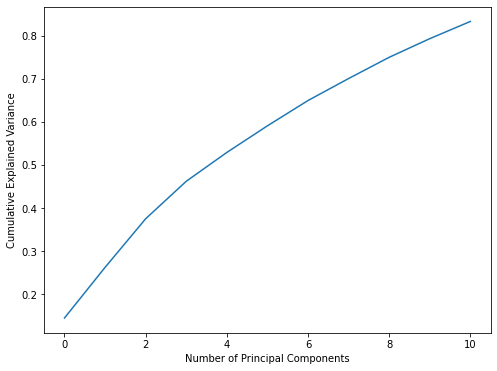

In [59]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print('Cumulative variance ratio: ', cumulative_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(range(len(cumulative_variance_ratio)), cumulative_variance_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

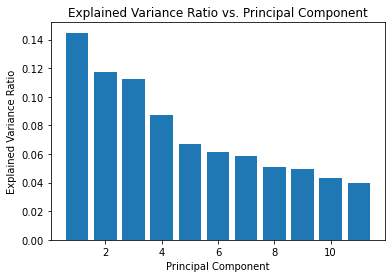

In [60]:
# Plot the degree of contribution of the principal components
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, align='center')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Principal Component')
plt.show()

In [61]:
# Apply PCA to my data
pca = PCA(n_components=11)
df_pca = pca.fit_transform(df)

In [62]:
# # 肘部法则
# sse = []
# list_k = list(range(1, 10))

# for k in list_k:
#     km = KMeans(n_clusters=k)
#     km.fit(x_pca)
#     sse.append(km.inertia_)

# # Plot sse against k
# plt.figure(figsize=(6, 6))
# plt.plot(list_k, sse, '-o')
# plt.xlabel(r'Number of clusters *k*')
# plt.ylabel('Sum of squared distance')
# plt.show()

In [63]:
from sklearn.cluster import KMeans

k = 3 
model = KMeans(n_clusters=k)

# Fit model to the PCA transformed data
model.fit(x_pca)
labels = model.labels_
df['Cluster'] = labels

In [64]:
df['Cluster']

0      2
1      2
2      1
3      0
4      1
      ..
241    0
242    2
243    2
244    2
245    2
Name: Cluster, Length: 246, dtype: int32

As our data now has 11 dimensions, we cannot visualise it directly in 2D or 3D space. We need to select some features or principal components for visualisation.

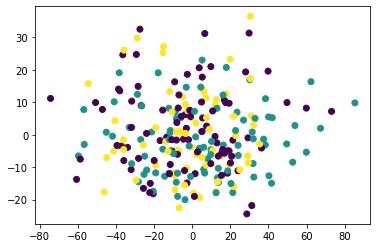

In [65]:
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels)
plt.show()

## Step 6: Modelling

In [64]:
X = df.drop('Result', axis=1)
y = df['Result']

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Naive Bayes

In [66]:
#The plain Bayesian model assumes that the features of the data are independent of each other
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)
print('Accuracy of Naive Bayes: ', accuracy_score(y_test, y_pred))
precision = precision_score(y_test, y_pred)
print('Precision of Naive Bayes: ', precision)
recall = recall_score(y_test, y_pred)
print('Recall of Naive Bayes: ', recall)
f1 = f1_score(y_test, y_pred)
print('F1 Score of Naive Bayes: ', f1)
y_score = nb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_score)
print('ROC-AUC of Naive Bayes: ', roc_auc)

Accuracy of Naive Bayes:  0.74
Precision of Naive Bayes:  0.75
Recall of Naive Bayes:  0.6521739130434783
F1 Score of Naive Bayes:  0.6976744186046512
ROC-AUC of Naive Bayes:  0.7697262479871176


In [67]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': np.linspace(0.1, 1, 10)}
grid_search = GridSearchCV(BernoulliNB(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print('Best parameter for Naive Bayes: ', grid_search.best_params_)

Best parameter for Naive Bayes:  {'alpha': 0.9}


In [68]:
clf_nb_optimized = BernoulliNB(alpha=0.9)
clf_nb_optimized.fit(X_train, y_train)

y_pred_nb_optimized = clf_nb_optimized.predict(X_test)
print('Accuracy of Naive Bayes with optimized alpha: ', accuracy_score(y_test, y_pred_nb_optimized))

Accuracy of Naive Bayes with optimized alpha:  0.46


## Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Accuracy of Logistic Regression: ', accuracy_score(y_test, y_pred))

precision = precision_score(y_test, y_pred)
print('Precision of Logistic Regression: ', precision)

recall = recall_score(y_test, y_pred)
print('Recall of Logistic Regression: ', recall)

f1 = f1_score(y_test, y_pred)
print('F1 Score of Logistic Regression: ', f1)

Accuracy of Logistic Regression:  0.8
Precision of Logistic Regression:  0.782608695652174
Recall of Logistic Regression:  0.782608695652174
F1 Score of Logistic Regression:  0.782608695652174


/Users/quinne/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [70]:
param_grid = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print('Best parameters for Logistic Regression: ', grid_search.best_params_)

/Users/quinne/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/quinne/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/quinne/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/quinne/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/quinne/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/quinne/miniforge3/envs/tf/lib/python3.8/sit

Best parameters for Logistic Regression:  {'C': 0.08858667904100823, 'penalty': 'l1'}


/Users/quinne/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/quinne/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/quinne/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [71]:
from sklearn.linear_model import LogisticRegression

clf_lr_optimized = LogisticRegression(C=0.08858667904100823, penalty='l1', solver='liblinear')
clf_lr_optimized.fit(X_train, y_train)

y_pred_lr_optimized = clf_lr_optimized.predict(X_test)
print('Accuracy of Logistic Regression with optimized parameters: ', accuracy_score(y_test, y_pred_lr_optimized))

Accuracy of Logistic Regression with optimized parameters:  0.76


## Tree based models

In [72]:
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train, y_train)

y_pred_tree = clf_tree.predict(X_test)
print('Accuracy of Decision Tree: ', accuracy_score(y_test, y_pred_tree))

Accuracy of Decision Tree:  0.68


In [73]:
from sklearn.ensemble import BaggingClassifier

clf_bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
clf_bagging.fit(X_train, y_train)

y_pred_bagging = clf_bagging.predict(X_test)
print('Accuracy of Bagging: ', accuracy_score(y_test, y_pred_bagging))

Accuracy of Bagging:  0.8


/Users/quinne/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [74]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)
clf_rf.fit(X_train, y_train)

y_pred_rf = clf_rf.predict(X_test)
print('Accuracy of Random Forest: ', accuracy_score(y_test, y_pred_rf))

Accuracy of Random Forest:  0.76


In [75]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
clf_gb.fit(X_train, y_train)

y_pred_gb = clf_gb.predict(X_test)
print('Accuracy of Gradient Boosting: ', accuracy_score(y_test, y_pred_gb))

Accuracy of Gradient Boosting:  0.7


## SVM

In [76]:
from sklearn import svm
from sklearn.metrics import accuracy_score

clf_svm = svm.SVC(kernel='linear', C=1, random_state=42)
clf_svm.fit(X_train, y_train)

y_pred_svm = clf_svm.predict(X_test)
print('Accuracy of SVM: ', accuracy_score(y_test, y_pred_svm))

Accuracy of SVM:  0.72


## KNN

In [77]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 25)}

knn_gscv = GridSearchCV(knn, param_grid, cv=5)
knn_gscv.fit(X_train, y_train)

print("Best parameter for KNN: ", knn_gscv.best_params_)

knn_best = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_['n_neighbors'])
knn_best.fit(X_train, y_train)

y_pred_knn = knn_best.predict(X_test)
print('Accuracy of KNN: ', accuracy_score(y_test, y_pred_knn))

Best parameter for KNN:  {'n_neighbors': 21}
Accuracy of KNN:  0.58


In [80]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 28.8 MB/s eta 0:00:0000:0100:01
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 23.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [81]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=500, 
                           depth=10, 
                           learning_rate=0.1, 
                           loss_function='Logloss', 
                           verbose=False)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy of CatBoost: ', accuracy_score(y_test, y_pred))

Accuracy of CatBoost:  0.86


/var/folders/1v/gbft9lh97dggng6ytnnwkd9c0000gn/T/ipykernel_46417/1551800908.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(X.columns, rotation=60)
/var/folders/1v/gbft9lh97dggng6ytnnwkd9c0000gn/T/ipykernel_46417/1551800908.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(X.columns, rotation=60)


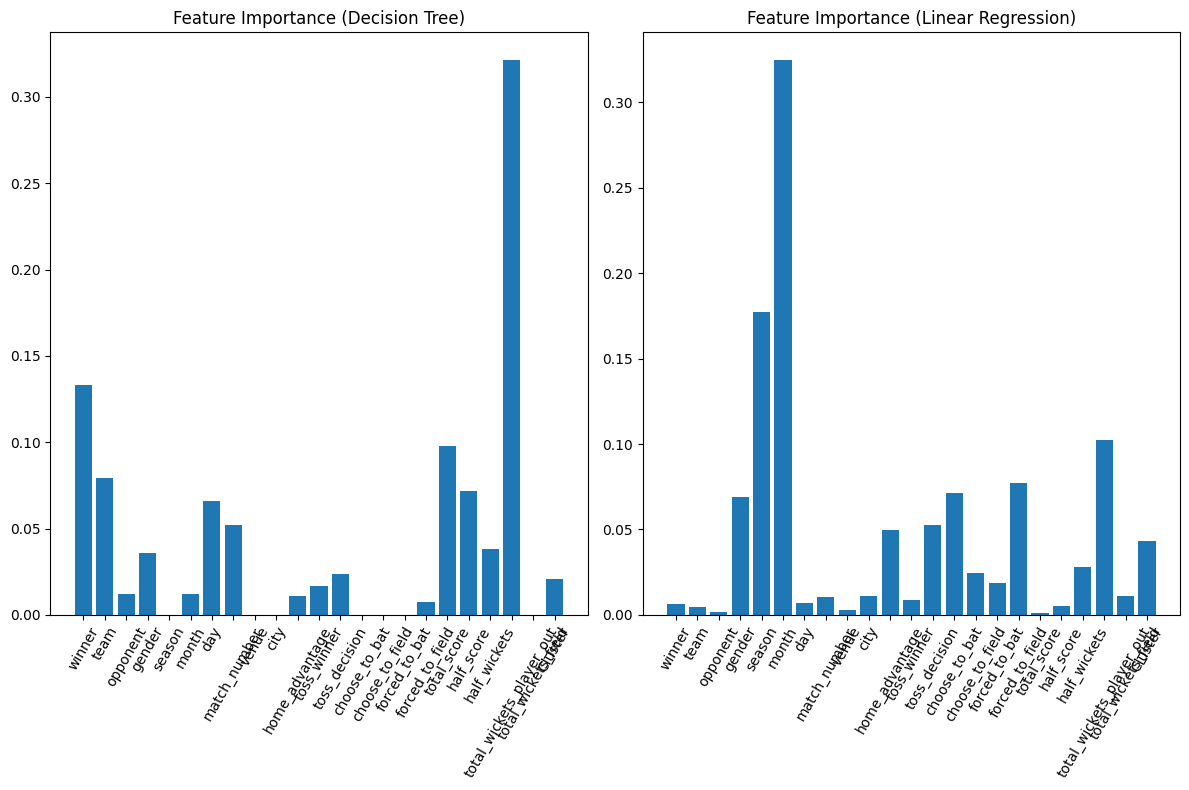

In [83]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

X = df.drop('Result', axis=1)
y = df['Result']

# Decision Tree Model
tree_model = DecisionTreeRegressor()
tree_model.fit(X, y)

# Linear Regression Model
linear_model = LinearRegression()
linear_model.fit(X, y)

# Compute the feature importances
tree_importances = tree_model.feature_importances_
linear_importances = abs(linear_model.coef_)

# Draw the feature importance ranking
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].bar(X.columns, tree_importances)
ax[0].set_title('Feature Importance (Decision Tree)')
ax[0].set_xticklabels(X.columns, rotation=60)
ax[1].bar(X.columns, linear_importances)
ax[1].set_title('Feature Importance (Linear Regression)')
ax[1].set_xticklabels(X.columns, rotation=60)
plt.tight_layout()
plt.show()